## Оптимізація SVM класифікатора

Параметри моделей машинного навчання вказані так, щоб їх поведінку можна було налаштувати згідно заданій проблемі. Моделі можуть мати багато параметрів, і пошук найкращої комбінації параметрів може розглядатися як проблема пошуку. В даному розділі налаштування параметрів моделі класифікації SVM відбувається за допомогою scikit-learn.

#### Завантаження бібліотек та даних

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#Біболіотеки для обробки даних
import pandas as pd #обробка даних, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

## Контрольоване навчання.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression

# візуалізація
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.titlesize'] = 'large'

#### Побудова моделі прогнозування та оцінка за допомогою 5-крокової валідації, використовуючи класифікатор SVM


The classifier accuracy score is 0.96


The 5-fold cross-validation accuracy score for this classifier is 0.98

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       107
           1       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



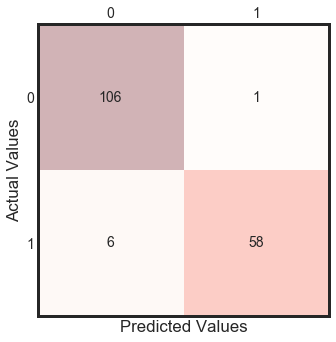

In [4]:
data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)


#Призначення предикторів до змінної типу ndarray (matrix)
array = data.values
X = array[:,1:31]
y = array[:,0]

#перетворення класових міток з рядкового в цілочисельне представлення
le = LabelEncoder()
y = le.fit_transform(y)

# Нормалізація даних
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

from sklearn.decomposition import PCA
# вилучення ознак
pca = PCA(n_components=10)
fit = pca.fit(Xs)
X_pca = pca.transform(Xs)

# 5. Розділення записів на тестові та навчальні.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=2, stratify=y)

# 6. Створення класифікатора SVM та його навчання на 70% даних.
clf = SVC(probability=True)
clf.fit(X_train, y_train)

 #7. Аналіз точності прогнозування на 30% тестових даних.
classifier_score = clf.score(X_test, y_test)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))

clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))
scores = cross_val_score(clf2, X_pca, y, cv=3)

# середня оцінка 5-крокової крос-валідації, використовуючи оцінювач SVC.
n_folds = 5
cv_error = np.average(cross_val_score(SVC(), X_pca, y, cv=n_folds))
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))

y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred ))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()

### Важливість оптимізації класифікатора

Можна налаштувати 2 ключових параметри класифікатора SVM:
1. Значення С (межа)
2. Тип ядра

Типовим для SVM (клас SVC) є використання ядра Radial Basis Function (RBF) зі значенням C, встановленим на 1,0. Як і в KNN, пошук буде здійснюватися по сітці, використовуючи 10-кратну крос-валідацію зі стандартизованою копією навчального набору даних. Буде використано ряд більш простих типів ядер та значень C із меншим зміщенням та більшою зміщеністю (менше та більше 1,0 відповідно).

In [5]:
# навчання класифікаторів
kernel_values = [ 'linear' ,  'poly' ,  'rbf' ,  'sigmoid' ]
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6),'kernel': kernel_values}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [6]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'} with a score of 0.98


In [7]:
grid.best_estimator_.probability = True
clf = grid.best_estimator_

[[107   0]
 [  5  59]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



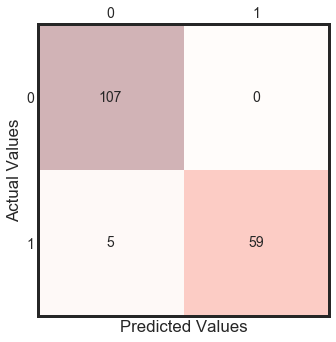

In [8]:
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred ))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()

### Межі рішення різних класифікаторів
Межі рішення, зроблені лінійними, гауссовими та поліноміальними класифікаторами.

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm, datasets

def decision_plot(X_train, y_train, n_neighbors, weights):
       h = .02  # розмір кроку в сітці

Xtrain = X_train[:, :2] # беремо лише перші дві ознаки

#================================================================
# Створення карт кольорів
#================================================================
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


#================================================================
# створення екземпляру SVM та даних з виправленням
# дані не масштабуються, оскільки будуються вектори підтримки
#================================================================

C = 1.0  # регулюючий параметр SVM

svm = SVC(kernel='linear', random_state=0, gamma=0.1, C=C).fit(Xtrain, y_train)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(Xtrain, y_train)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(Xtrain, y_train)

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'
    
    # створення сітки для побудови
x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

# надписи для графіків
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

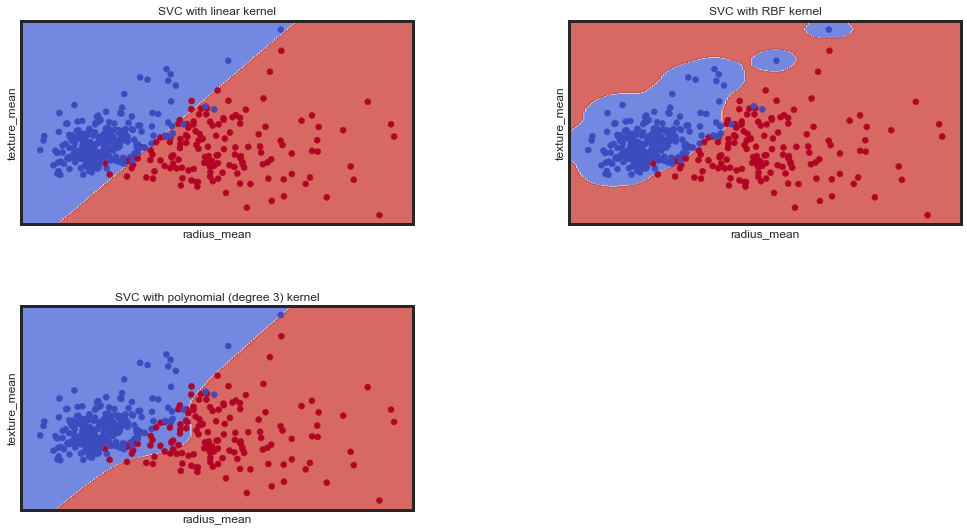

In [11]:
for i, clf in enumerate((svm, rbf_svc, poly_svc)):
    # межі рішення позначені кольорами
    # точка на сітці [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # зображення результатів на кольоровому графіку
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # зображення на графіку точок навчання
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=y_train, cmap=plt.cm.coolwarm)
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

### Висновок

Даний розділ демонструє моделювання раку молочної залози як завдання класифікації за допомогою SVM.

SVM працює краще, коли набір даних стандартизований: всі атрибути мають середнє значення нуля та стандартне відхилення - одиницю. Ми можемо обчислити це з усього навчального набору даних і застосувати те саме перетворення до вхідних атрибутів з тестового набору даних.